<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE32338](https://jckantor.github.io/CBE32338)
by Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE2338.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [State Estimation](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/03.00-State-Estimation.ipynb) | [Contents](toc.ipynb) | [Feedback Control](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/04.00-Feedback-Control.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE32338/blob/master/notebooks/03.01-Open-and-Closed-Loop-Estimation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE32338/master/notebooks/03.01-Open-and-Closed-Loop-Estimation.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Open and Closed Loop Estimation

This notebook outlines three experiments to be performed using the TCLab hardware. This first cell imports necessary libraries, defines a relay control as a Python generator, and a temperature setpoint corresponding to a ramp/soak cycle.

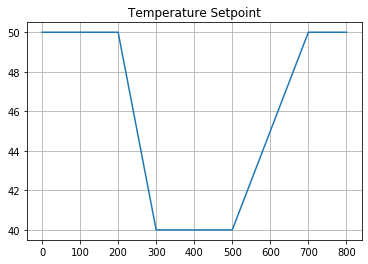

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control
import pandas as pd

# Relay Control
def relay(Qmin, Qmax):
    Q = 0
    while True:
        Tsp, T = yield Q
        Q = Qmax if T < Tsp else Qmin
        
# Temperature Setpoint
def Tsp(t):
    tp = [  0,  200,  300,  500,  700, 9999]
    Tp = [ 50,   50,   40,   40,   50,   50]
    return np.interp(t, tp, Tp)

t = np.linspace(0, 800, 801)
plt.plot(t, Tsp(t))
plt.title('Temperature Setpoint')
plt.grid()

## Experiment 1. Open-Loop State Estimation and Relay Control

In this first experiment, use a closed loop estimator and relay control to cause the heater to track a desired temperature setpoint. Perform the following tasks:

**a.**) This code was cut and paste from Thursday's lecture. Adjust the setup to interface with the lab device rather than simuation. Modify the parameters to reflect the model you previously fit to the TCLab hardware.

**b.**) When you run the experiment, keep the Arduino/TCLab device carefully shielded from any air currents. For example, you might use the plastic lab kit as a shield.

**c.**) Describe what you see. Does the controller track the setpoint?  Does the controller reject disturbances?  Explain why this system displays the behavior you're seeing.

### Open Loop Estimation

In [4]:
import numpy as np
import control 

# This function runs a model of the temperature control lab in parallel
# with real-time control. This uses the Python 'yield' statement o 
# share data with a calling script.

def tclab():
    # parameter estimates. Modify these to reflect your model fit.
    P =  0.04             # power input when the system is turned
    Ua = 0.068            # heat transfer coefficient from heater to environment
    CpH = 6.50            # heat capacity of the heater (J/deg C)
    CpS = 1.25            # heat capacity of the sensor (J/deg C)
    Uc = 0.036            # heat transfer coefficient from heater to sensor
    Tamb = 21             # ambient room temperature

    # state space model
    A = [[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]]
    B = [[P/CpH], [0]] # single column
    C = [[0, 1]]   # single row
    D = [[0]]

    # initialize variables that will be updated in time
    t = 0
    x = np.array([0, 0])
    
    while True:
        # yield the heater temperature to the calling program
        Th = x[0] + Tamb
        Ts = x[1] + Tamb
        tnext, Q, T1 = yield Th, Ts
        dt = tnext - t
        x = x + dt*np.dot(A, x) + dt*np.dot(B, [Q])
        t = tnext

### Event Loop

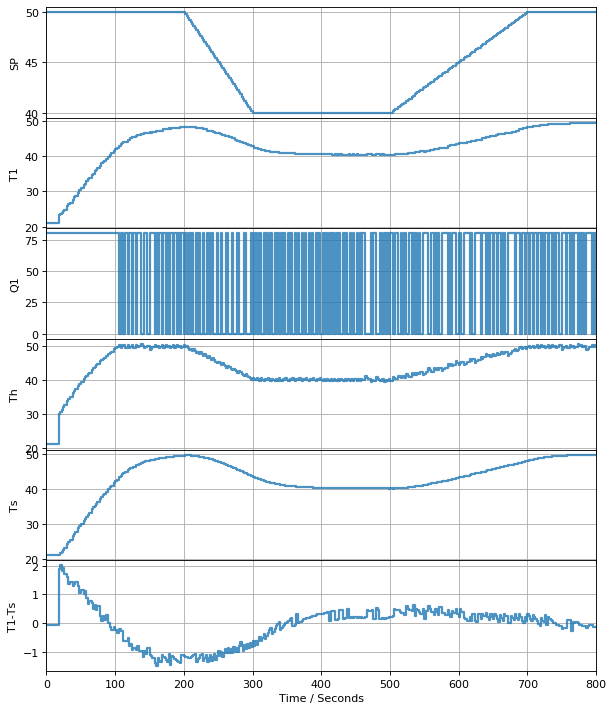

TCLab Model disconnected successfully.


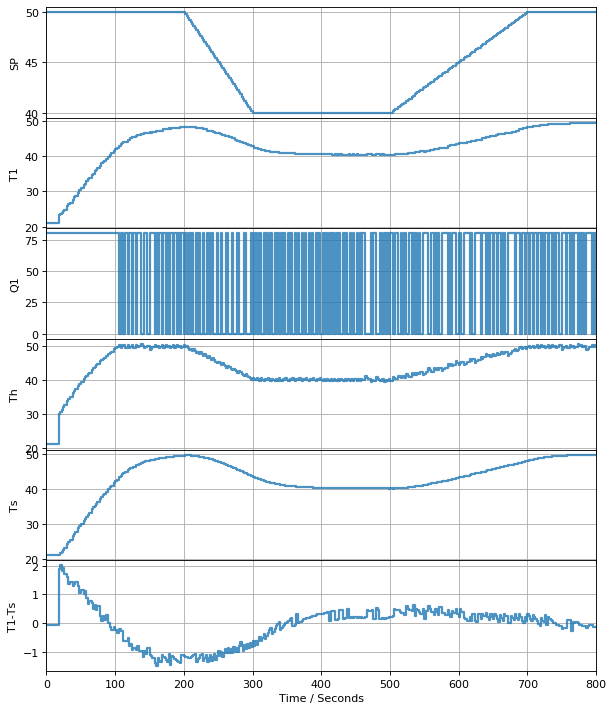

In [5]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

tf = 800        # run time

# create a controller instance
controller = relay(0, 80)
controller.send(None)

# create an model estimator
estimator = tclab()
estimator.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('SP', lambda: Tsp(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1),
                   ('Th', lambda: Th), ('Ts', lambda: Ts), ('T1-Ts', lambda: T1-Ts)])
    p = Plotter(h, tf)
    U1 = 0
    for t in clock(tf, 2):                    # allow time for more calculations
        T1 = lab.T1                           # measure the sensor temperature
        Th, Ts = estimator.send([t, U1, T1])  # estimate the heater temperature
        SP = Tsp(t)                           # get setpoint
        U1 = controller.send([SP, Th])        # compute control action
        lab.U1 = U1                           # set manipulated variable  
        p.update(t)                           # log data

## Experiment 2. Closed-Loop State Estimation and Relay Control

In the second experiment, use a closed loop estimator and relay control to cause the heater to track a desired temperature setpoint. 

Before performing the experiment, you will need to determine suitable values for the observer gain $L$.  $L$ is a matrix consisting of two rows and one column.  You need to choose the values in $L$ such that $A-LC$ is stable and has acceptable time constants. For this experiment we will use a pole placement technique to determine $L$.

\begin{align*}
L & = \begin{bmatrix} ? \\ ? \end{bmatrix}
\end{align*}

**a.**) Before starting the experiment, compute the eigenvalues and corresponding time constants of $A$ and of $A-LC$. 

**b.**) Then repeat the same tasks for Experiment 1, but this time use a closed-loop estimator. In your answers, be sure to describe how the results of this experiment differ from the first, and explain why.

### Review of Closed Loop Estimation

Examining the results, we see the predicted heater temperature appears to track the desired setpoint, but the sensor temperature is off the mark. This could be due several factors, most likely model error.

Process
\begin{align*}
\frac{dx}{dt} & = A x + B u \\
y & = C x + D u
\end{align*}

Model
\begin{align*}
\frac{d\hat{x}}{dt} & = A \hat{x} + B u \\
\hat{y} & = C \hat{x} + D u
\end{align*}

If the measured and estimated outputs are different, then $y - \hat{y} \neq 0$. Taking the difference we find

\begin{align*}
y - \hat{y} & = C x + Du - C\hat{x} - Du \\
& = C(x - \hat{x})
\end{align*}

The difference $y - \hat{y}$ can be observed.  But what we want is to make $x - \hat{x}$ small. Is there way to use knowledge of $y - \hat{y}$ to reduce $x - \hat{x}$?

The technique is to introduce feedback $L(y-\hat{y})$ to the model.  

\begin{align*}
\frac{d\hat{x}}{dt} & = A \hat{x} + B u + L(y - \hat{y}) \\
\hat{y} & = C \hat{x} + D u
\end{align*}

Subtracting the new model equations from the process model, we get an expression for the dynamics of the model error $e = x - \hat{x]$

\begin{align*}
\frac{de}{dt} & = \frac{dx}{dt} - \frac{d\hat{x}}{dt} \\
\\
& = (Ax + Bu) - (A\hat{x} + Bu + L(Cx - C\hat{x})) \\
\\
& = (A - LC)(x -\hat{x}) \\
\\
\frac{de}{dt} & = (A - LC) e
\end{align*}

The choice of $L$ determines observer performance.

### Choosing $L$

In [18]:
import numpy as np
from scipy.signal import place_poles

P =  0.04             # power input when the system is turned
Ua = 0.068            # heat transfer coefficient from heater to environment
CpH = 6.50            # heat capacity of the heater (J/deg C)
CpS = 1.25            # heat capacity of the sensor (J/deg C)
Uc = 0.036            # heat transfer coefficient from heater to sensor
Tamb = 21             # ambient room temperature

# state space model
A = np.array([[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]])
C = np.array([[0, 1]])  # single row

# be sure all eigenvalues have negative real parts
assert(all(np.real(eigenvalues) < 0))

# get the eigenvalues of A and report time constants
eigenvalues, _ = np.linalg.eig(A)
print('Time constants of A are:', -1.0/np.real(eigenvalues), 'seconds')

# place poles of observer to be at least three time faster than open loop estimator
# L = place_poles(A.T, C.T, 3*eigenvalues).gain_matrix

Time constants of A are: [121.33951135  27.35329911] seconds


In the next cell, choose values for L that cause both time constants of the observer to be smaller than the times constants of A, but keep the component values of L small.  This will require some trial and error.

In [19]:
L = np.array([[2],[2]])

eigenvalues_observer, _ = np.linalg.eig(A - np.dot(L, C))
print('Time constants of A - LC are:', -1.0/np.real(eigenvalues_observer), 'seconds')

Time constants of A - LC are: [22.24490704  0.50003853] seconds


In [33]:
import numpy as np
import control 

# The following function implements a state observer

def tclab():
    # parameter estimates
    P =  0.04             # power input when the system is turned
    Ua = 0.068            # heat transfer coefficient from heater to environment
    CpH = 6.50            # heat capacity of the heater (J/deg C)
    CpS = 1.25            # heat capacity of the sensor (J/deg C)
    Uc = 0.036            # heat transfer coefficient from heater to sensor
    Tamb = 21             # ambient room temperature

    # state space model
    A = [[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]]
    B = [[P/CpH], [0]] # single column
    C = [[0, 1]]   # single row
    D = [[0]]

    # initialize variables that will be updated in time
    t = 0
    x = np.array([0, 0])
    
    # observer gain ... put your values here!
    L = [[0.6], [0.3]]
    
    while True:
        # yield the heater temperature to the calling program
        Th = x[0] + Tamb
        Ts = x[1] + Tamb
        tnext, Q, T1 = yield Th, Ts
        dt = tnext - t
        x = x + dt*np.dot(A, x) + dt*np.dot(B, [Q]) + dt*np.dot(L, [T1-Ts])
        t = tnext

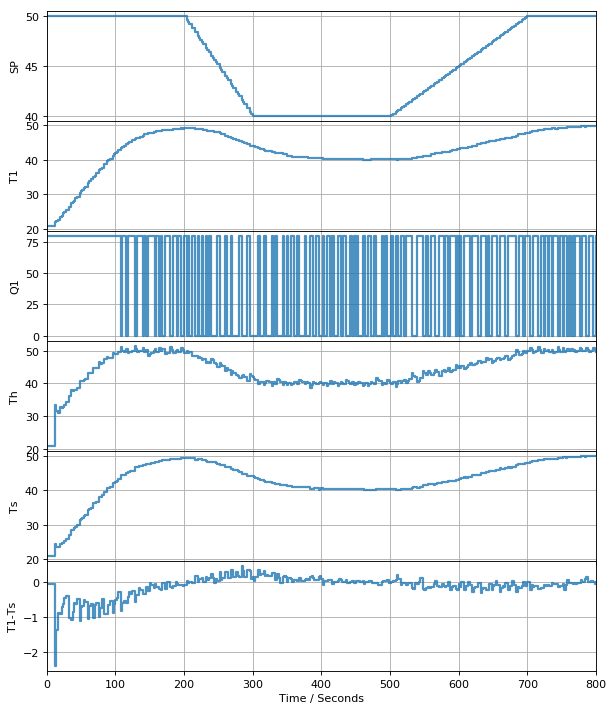

TCLab Model disconnected successfully.


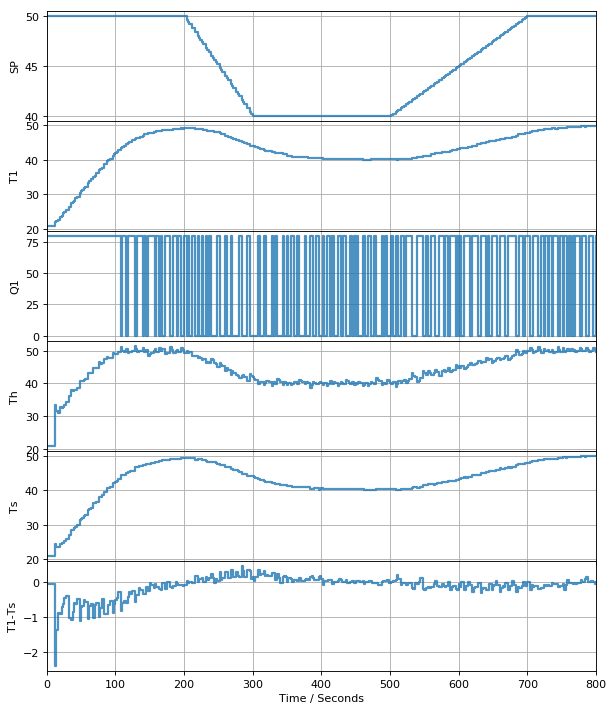

In [34]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

tf = 800        # run time

# create a controller instance
controller = relay(0, 80)
controller.send(None)

# create an model estimator
estimator = tclab()
estimator.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('SP', lambda: Tsp(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1),
                   ('Th', lambda: Th), ('Ts', lambda: Ts), ('T1-Ts', lambda: T1-Ts)])
    p = Plotter(h, tf)
    U1 = 0
    for t in clock(tf, 2):                    # allow time for more calculations
        T1 = lab.T1                           # measure the sensor temperature
        Th, Ts = estimator.send([t, U1, T1])  # estimate the heater temperature
        SP = Tsp(t)                           # get setpoint
        U1 = controller.send([SP, Th])        # compute control action
        lab.U1 = U1                           # set manipulated variable  
        p.update(t)                           # log data

## Question

Be sure to review the code given above to understand how this code is working. Then, in the cells below, implement a proportional controller with a proportional control gain Kp = 0.8. Test the controller in simulation mode.

<!--NAVIGATION-->
< [State Estimation](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/03.00-State-Estimation.ipynb) | [Contents](toc.ipynb) | [Feedback Control](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/04.00-Feedback-Control.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE32338/blob/master/notebooks/03.01-Open-and-Closed-Loop-Estimation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE32338/master/notebooks/03.01-Open-and-Closed-Loop-Estimation.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

<!--NAVIGATION-->
< [State Estimation](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/03.00-State-Estimation.ipynb) | [Contents](toc.ipynb) | [Feedback Control](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/04.00-Feedback-Control.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE32338/blob/master/notebooks/03.01-Open-and-Closed-Loop-Estimation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE32338/master/notebooks/03.01-Open-and-Closed-Loop-Estimation.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>